 ## <center>Practicing Machine Learning</center>
### <center>Simple Regression Analysis </center>
#### <center>California Housing Price Prediction </center>
##### <center> Recommended Source: <a href="https://www.amazon.com/-/es/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_fkmr1_1?__mk_es_US=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2Y7BISU0SQYCV&keywords=hand+son+machine+learning+tensorflow+keras&qid=1664596219&qu=eyJxc2MiOiIwLjkzIiwicXNhIjoiMC4wMCIsInFzcCI6IjAuMDAifQ%3D%3D&sprefix=hand+son+machine+learning+tensorflow+keras%2Caps%2C105&sr=8-1-fkmr1">Link</a></center>


### Loading required imports

In [63]:
import pandas as pd
import os
import tarfile
import urllib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

### Getting the Housing Dataset for California

In [64]:
DL_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DL_ROOT + "datasets/housing/housing.tgz"

In [65]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

#### Basic Exploration
After loading the data it's a good practice to review the data and gain insights. The first part of this process is getting a description of the data, so we can know what we are working with.

In [66]:
housing_data = pd.read_csv(os.path.join(HOUSING_PATH, "housing.csv"))
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [67]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [68]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Now that we have seen the data description we know the following:
<li>We have 9 continuous variables and one categorical</li>
<li>we have 5 categories in the categorical variable 'ocean_proximity'</li>
<li>'total_bedrooms' is missing values since the total count of items is 20640 and we got 20433</li>
<li>there is a huge difference between max and 75% percentile of 'median_income' meaning that 75% of owners make less than 474000 or less per year and there are some outliers that take the max value to over 1,500,000</li>
<li>there is a huge difference between max and 75% percentile of 'median_house_value' meaning that 75% of houses cost 264,725 or less and there are outliers that take the max value over 500001</li>


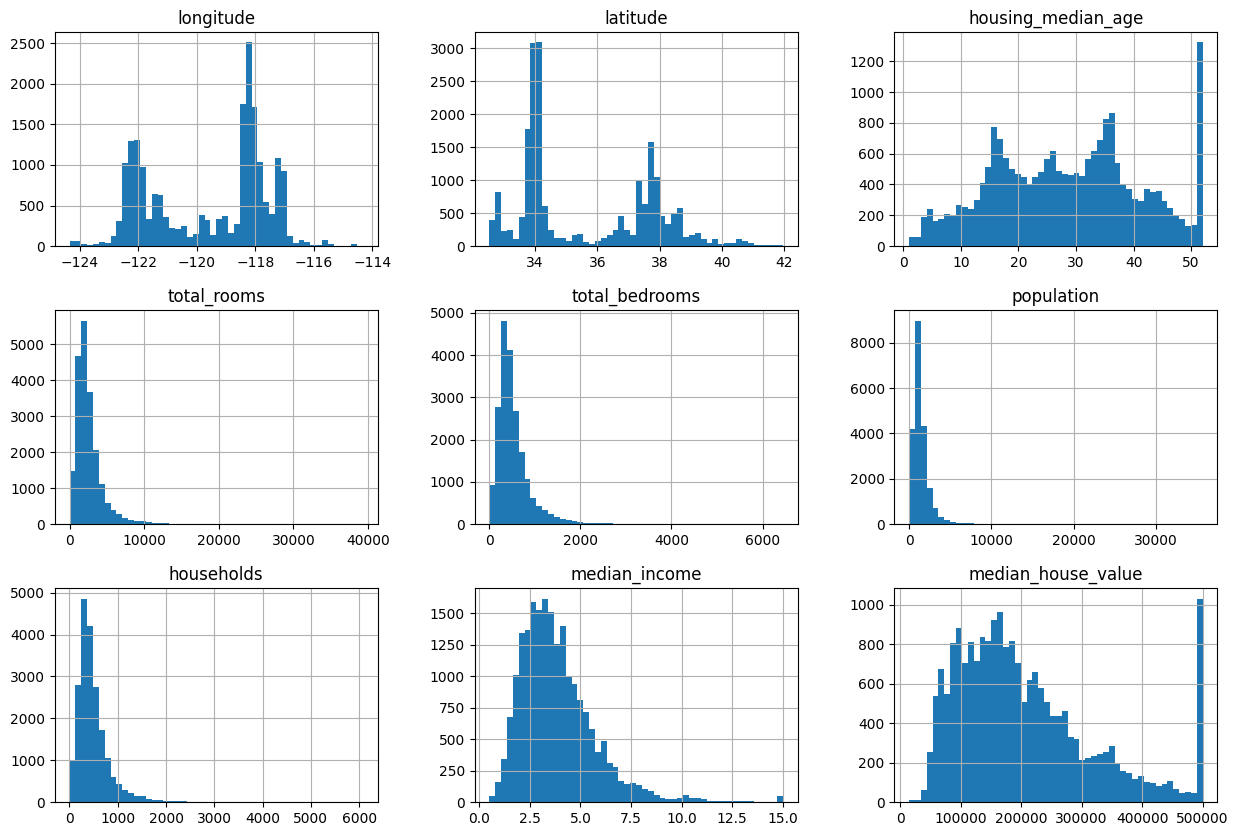

In [69]:
housing_data.hist(bins=50, figsize=(15,10))
plt.show()

After reviewing the data distribution I noticed that the 'median_house_value' was probably limited by whoever took this dataset meaning that they capped it at 500,000 usd so all houses above that price were set at 500,000 usd. Not the best thing to do in this case you can either contact whoever did this, or maybe even discard this since it will skew our models judging by the seen frequency of the value.

In [70]:
housing_data = housing_data[housing_data['median_house_value']<500000].reset_index(0)

### Data Preparation

We have seen all we can from the data now let's see what we can do with it to make it better. In this phase we have to work on the data depending on what we saw in the data to prepare it for training and evaluating different models.

### Data Separation Techniques
The first technique to be displayed is the standard 'train_test_split function' in our scikit-learn distribution. This method is generally good in dividing data for training and testing.

In [106]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=1989)
len(train_set)

15718

In [107]:
len(test_set)

3930

The only downside is that this method relies solely on random sampling but what happens when data is inherently categorized in subgroups, this method would be heavily biased, eg. a dataset with 55% men and 45% women will be skewed.

Assuming the median income is a very important attribute to predict median housing prices. It is important that we ensure that the test set is representative of income categories. For this we will need to play around with the bin # factor in the pandas.cut() function which creates categories based on a number of bins. These bins need to represent the data so keep that in mind when you check the data.

<AxesSubplot: >

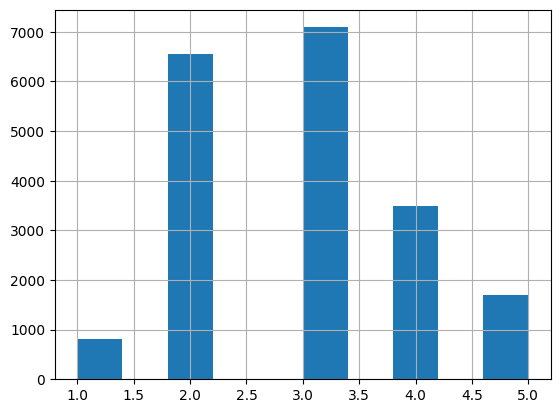

In [72]:
housing_data['income_cat'] = pd.cut(housing_data['median_income'],bins=[0,1.5,3.,4.5,6., np.inf],labels=[1,2,3,4,5])
housing_data['income_cat'].hist()

To take into account these subgroups we will leverage the 'Stratified_Shuffle_Split()' function that allows us to take into account the proportion or stratification in these subgroups, in other words it is a stratified sampling method.

In [73]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1989)

After splitting the data we define our new stratified train and test sets as seen below.

In [74]:
for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [75]:
strat_test_set['income_cat'].value_counts()/ len(strat_test_set)

3    0.360814
2    0.333333
4    0.177863
5    0.086514
1    0.041476
Name: income_cat, dtype: float64

<AxesSubplot: >

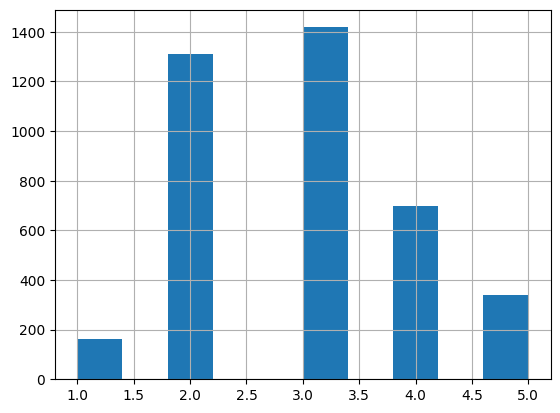

In [76]:
strat_test_set['income_cat'].hist()

In [77]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [78]:
housing = strat_train_set.copy()

C:\Users\Usuario1\anaconda3\envs\Machine Learning Topics Explanation\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

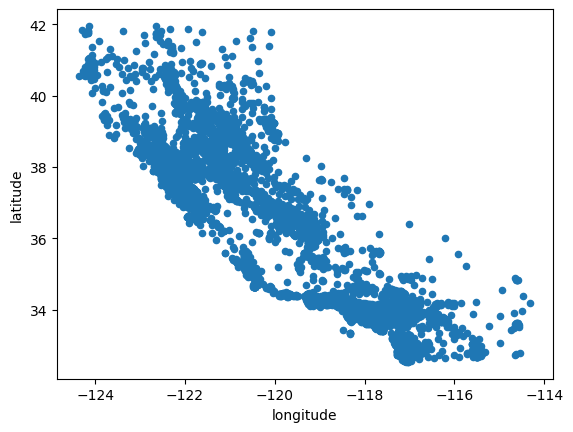

In [79]:
housing.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

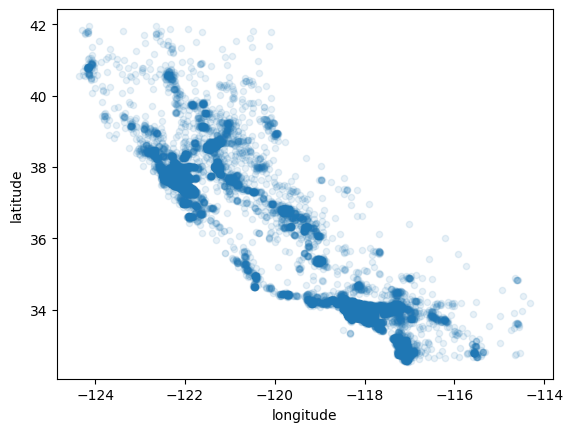

In [80]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

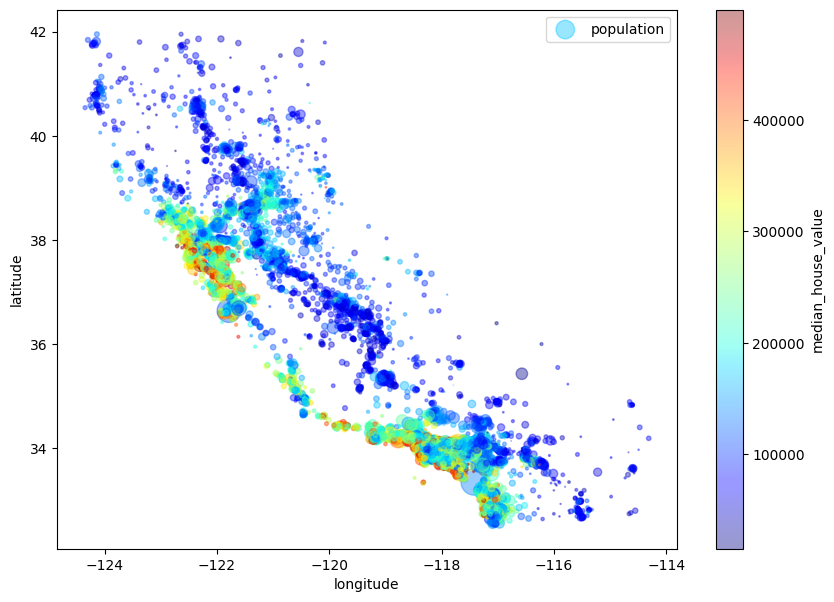

In [81]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7), c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [82]:
corr_matrix = housing.corr()

In [83]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.650120
total_rooms           0.153225
households            0.103477
total_bedrooms        0.083306
index                 0.066936
housing_median_age    0.060428
population            0.020185
longitude            -0.043466
latitude             -0.152561
Name: median_house_value, dtype: float64

In [84]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='population_per_household', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot: xlabel='rooms_per_household', ylabel='median_income'>,
        <AxesSubplot: xlabel='bedrooms_per_room', ylabel='median_inco

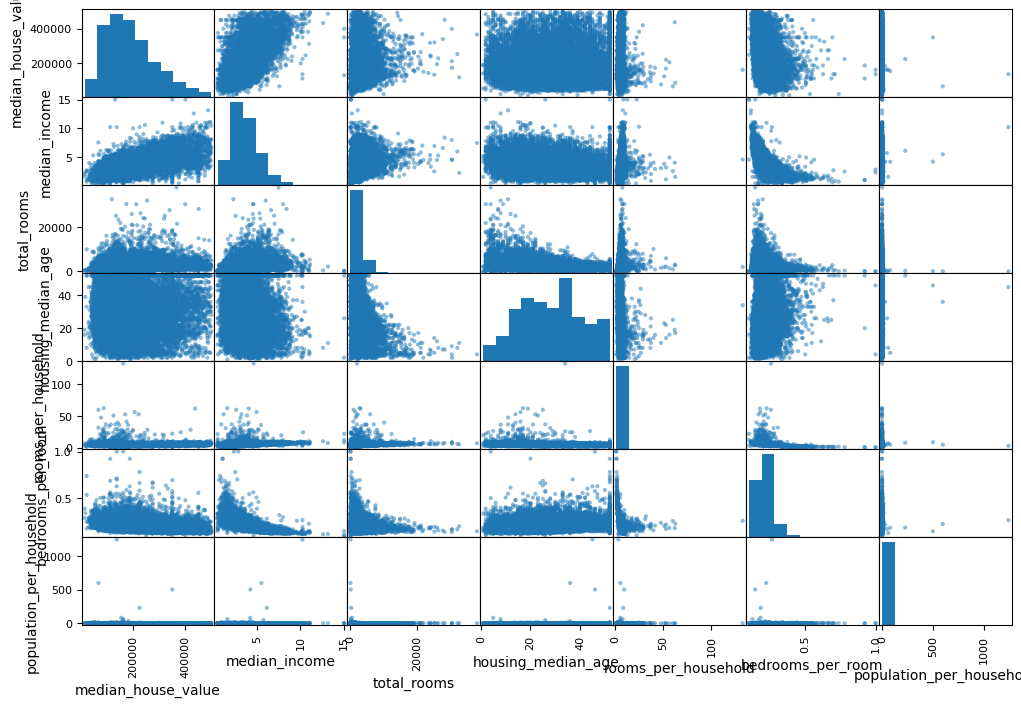

In [85]:
scatter_matrix(housing[['median_house_value','median_income','total_rooms', 'housing_median_age', 'rooms_per_household','bedrooms_per_room', 'population_per_household']], figsize=(12,8))

In [86]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.650120
total_rooms                 0.153225
rooms_per_household         0.107635
households                  0.103477
total_bedrooms              0.083306
index                       0.066936
housing_median_age          0.060428
population                  0.020185
population_per_household   -0.019791
longitude                  -0.043466
latitude                   -0.152561
bedrooms_per_room          -0.218855
Name: median_house_value, dtype: float64

### Data Preparation

In [87]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
x= imputer.transform(housing_num)
housing_transformed = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [88]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [89]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])

In [90]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),

])
num_pipeline.fit_transform(housing_num)


num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

### Model Selection

In [91]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, strat_train_set['median_house_value'].copy())

LinearRegression()

In [92]:
predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(strat_train_set['median_house_value'].copy(), predictions)
rmse = np.sqrt(mse)
rmse

5.6817383921773135e-11

In [93]:
tree_reg = DecisionTreeRegressor(
)
tree_reg.fit(housing_prepared, strat_train_set['median_house_value'].copy())
predictions = tree_reg.predict(housing_prepared)
rmse = np.sqrt(mean_squared_error(strat_train_set['median_house_value'].copy(), predictions))
rmse

0.0

In [94]:
housing_labels = strat_train_set['median_house_value'].copy()
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [95]:
tree_rsme = np.sqrt(-scores)
tree_rsme

array([112.96377406,  96.7013187 , 108.07122333, 116.86642295,
       214.54727766, 177.00145914, 101.43688106,  93.59242483,
       114.39932518,  98.16910805])

In [96]:
def display_scores(scores):
    print("scores ", scores)
    print("mean ", scores.mean())
    print("STD", scores.std())
display_scores(tree_rsme)

scores  [112.96377406  96.7013187  108.07122333 116.86642295 214.54727766
 177.00145914 101.43688106  93.59242483 114.39932518  98.16910805]
mean  123.374921496484
STD 37.906213162657885


In [97]:
param_grid = [
    {
        'n_estimators': [3, 10, 30],
        "max_features": [2, 4, 6, 8],
    },
    {
        "bootstrap": [False],
        "n_estimators": [3, 10],
        "max_features": [2, 3, 4]
    }
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=7, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=7, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [98]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [99]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [100]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score),params)

32831.29605961067 {'max_features': 2, 'n_estimators': 3}
23366.207713547705 {'max_features': 2, 'n_estimators': 10}
21061.93760160192 {'max_features': 2, 'n_estimators': 30}
16833.45460370882 {'max_features': 4, 'n_estimators': 3}
12360.725387511127 {'max_features': 4, 'n_estimators': 10}
10289.357058652447 {'max_features': 4, 'n_estimators': 30}
10424.790576207637 {'max_features': 6, 'n_estimators': 3}
7562.52883125778 {'max_features': 6, 'n_estimators': 10}
5651.626038418219 {'max_features': 6, 'n_estimators': 30}
6253.669868092857 {'max_features': 8, 'n_estimators': 3}
3959.733257543908 {'max_features': 8, 'n_estimators': 10}
3076.0150899595455 {'max_features': 8, 'n_estimators': 30}
30881.59810319174 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
22242.86518583085 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
21836.149478365205 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
15715.326898820867 {'bootstrap': False, 'max_features': 3, 'n_estimator

#### Analyze best models and their errors

In [101]:
feature_importances = grid_search.best_estimator_

## Trying model on Test Data

In [102]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.copy()#.drop("median_house_value", axis=1)
X_test['rooms_per_household'] = X_test['total_rooms']/X_test['households']
X_test['bedrooms_per_room'] = X_test['total_bedrooms']/X_test['total_rooms']
X_test['population_per_household'] = X_test['population']/X_test['households']
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2627.458988751241

### Analyzing the result with T test

In [103]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(
    stats.t.interval(
    confidence,
    len(
            squared_errors
        ),
    loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)
    )
)

array([2326.01710662, 2897.71045738])